In [260]:
import matplotlib.pyplot as plt


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [530]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF
import seaborn as sns
import polars as pl
from datetime import datetime
from ladybug.dt import DateTime
from matplotlib.patches import FancyArrowPatch
from itertools import accumulate

from case_edits.ezcase import *
from helpers.ep_helpers import *
from helpers.ep_geom_helpers import *
from helpers.geometry_interfaces import *
from helpers.helpers import *
from plan.helpers import get_plans_from_file
from network.network import *
from network.visuals import *
from subsurfaces.logic import get_connecting_surface
from helpers.variables import *
from helpers.variable_interfaces import *
from helpers.read_sql import *

from case_edits.epcase import EneryPlusCaseEditor
from helpers.output_requests import request_sql

from setup.setup import get_case_names, CaseData, retrieve_cases
from setup.plots import *
from setup.data_wrangle import *
from network.data_on_network import *

import matplotlib.cm as cm
import matplotlib as mpl




In [529]:
from matplotlib.cm import ScalarMappable

In [205]:
qoi1 = 'AFN Linkage Node 1 to Node 2 Volume Flow Rate'
qoi12 = 'AFN Linkage Node 2 to Node 1 Volume Flow Rate'

qoi2 = "Site Wind Speed"
qoi3 = "Site Wind Direction"

qoi4 = all_variables.afn.zone["ach"]

In [495]:
case_data = retrieve_cases()
sample_case  = case_data[2]
case_name, idf, sql, path_to_input, path_to_output = sample_case

In [496]:
qois = [qoi1, qoi12]
# df = create_dataframe_for_all_cases(case_data, qoi1)
# # df2 = join_site_data(sample_case, qoi2, df1, 1)
# df1 = join_any_data(df, case_data, qoi12)
# df_case = df1.filter(pl.col("case_names") == sample_case.case_name)
# df_case.head()

case_names,space_names,qoi,values,datetimes,qoi_0,values_0
str,str,str,f64,datetime[μs],str,f64
"""red_b1""","""BLOCK 09 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.180699,2017-07-01 00:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.045866
"""red_b1""","""BLOCK 09 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.217432,2017-07-01 00:15:00,"""AFN Linkage Node 2 to Node 1 V…",0.049305
"""red_b1""","""BLOCK 09 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.241523,2017-07-01 00:30:00,"""AFN Linkage Node 2 to Node 1 V…",0.068703
"""red_b1""","""BLOCK 09 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.19673,2017-07-01 00:45:00,"""AFN Linkage Node 2 to Node 1 V…",0.125898
"""red_b1""","""BLOCK 09 STOREY 0 WALL 0001_2 …","""AFN Linkage Node 1 to Node 2 V…",0.233173,2017-07-01 01:00:00,"""AFN Linkage Node 2 to Node 1 V…",0.101134


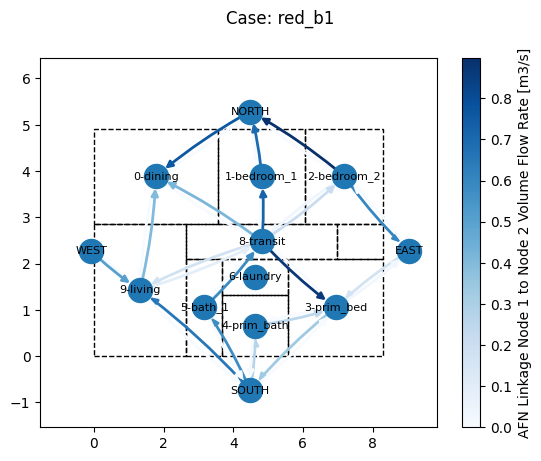

In [535]:
qois = [qoi1, qoi12]
fig = create_data_on_network_fig(case_data, sample_case, qois)


In [497]:
medians = df_case.group_by(pl.col("space_names")).agg(pl.col(["values", "values_0"]).median())
medians

space_names,values,values_0
str,f64,f64
"""BLOCK 03 STOREY 0 WALL 0001 WI…",0.170261,0.024615
"""BLOCK 02 STOREY 0 WALL 0001 WI…",0.600622,0.0
"""BLOCK 09 STOREY 0 WALL 0003 WI…",0.000172,0.503303
"""BLOCK 05 STOREY 0 WALL 0004 WI…",0.578701,0.0
"""BLOCK 05 STOREY 0 WALL 0002_1 …",0.0,0.583702
…,…,…
"""BLOCK 09 STOREY 0 WALL 0001_2 …",0.173385,0.089244
"""BLOCK 09 STOREY 0 WALL 0004 WI…",0.654377,0.0
"""BLOCK 03 STOREY 0 WALL 0002_2 …",0.0,0.869638


In [514]:
assert medians.schema == pl.Schema([('space_names', pl.String), ('values', pl.Float64), ('values_0', pl.Float64)])

In [513]:
type(medians.schema["space_names"])

String

In [498]:
max_val = medians.select(pl.selectors.numeric()).max_horizontal().max()
min_val = medians.select(pl.selectors.numeric()).min_horizontal().min()
min_val, max_val

(0.0, 0.8986780233662481)

In [528]:
type(max_val)

float

In [499]:
G, pos = create_base_graph(idf, path_to_input)
Gm = create_multi_graph(G)

In [500]:
edges = [get_matching_edge(Gm, s) for s in medians["space_names"]]
rev_edges = [(e[1], e[0], e[2]) for e in edges]
rev_edges

[('3-prim_bed', 'EAST', 0),
 ('EAST', '2-bedroom_2', 0),
 ('WEST', '9-living', 0),
 ('5-bath_1', 'SOUTH', 0),
 ('5-bath_1', '8-transit', 0),
 ('1-bedroom_1', 'NORTH', 0),
 ('8-transit', '0-dining', 0),
 ('2-bedroom_2', 'NORTH', 0),
 ('4-prim_bath', '3-prim_bed', 0),
 ('NORTH', '0-dining', 0),
 ('8-transit', '1-bedroom_1', 0),
 ('8-transit', '2-bedroom_2', 0),
 ('9-living', '0-dining', 0),
 ('9-living', '8-transit', 0),
 ('9-living', 'SOUTH', 0),
 ('8-transit', '3-prim_bed', 0),
 ('SOUTH', '3-prim_bed', 0),
 ('4-prim_bath', 'SOUTH', 0)]

In [501]:
case_info, qoi_info = get_plot_labels(sample_case, qoi1)

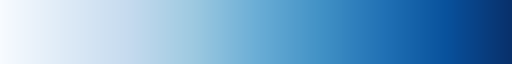

In [502]:
cmap = plt.get_cmap("Blues")
cmap

In [503]:
zone_domains = get_zone_domains(sample_case.idf)

def get_domain_lim(zone_domains: list[Domain]):
    PAD = 1.4*1.1
    min_x = min([i.width.min for i in zone_domains]) - PAD
    max_x = max([i.width.max for i in zone_domains]) + PAD
    min_y = min([i.height.min for i in zone_domains]) - PAD
    max_y = max([i.height.max for i in zone_domains]) + PAD
    return (min_x, max_x), (min_y, max_y)

# ylim = [(i.height.min, i.height.max) for i in zone_domains]
# xlim = [min(i) for i in xlim]

In [504]:
import matplotlib.ticker as ticker

In [518]:
[f"arc3,rad={r}" for r in [0.05] * 2]

['arc3,rad=0.05', 'arc3,rad=0.05']

tuple

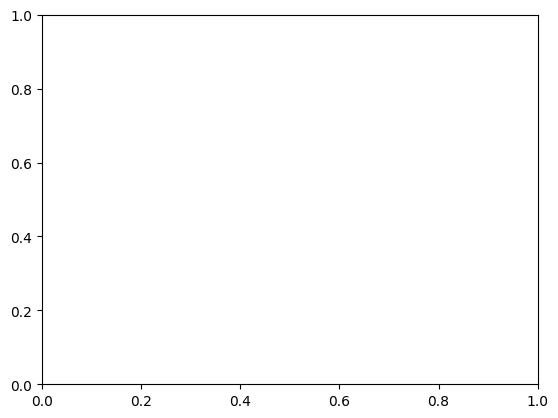

In [523]:
a = plt.subplots()
type(a)

In [527]:
type(plt.get_cmap())

matplotlib.colors.ListedColormap

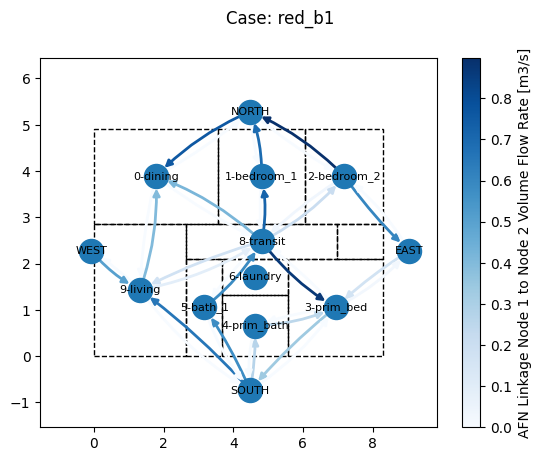

In [505]:
connectionstyle = [f"arc3,rad={r}" for r in accumulate([0.05] * 2)]
xlim, ylim = get_domain_lim(zone_domains)

fig, ax = plt.subplots()

for d in zone_domains:
    ax.add_artist(d.get_mpl_patch())

ax.set(xlim=xlim, ylim=ylim)

# fig, ax = plt.subplots()
_ = nx.draw_networkx_nodes(Gm, pos, ax=ax, hide_ticks=False)
p = nx.draw_networkx_labels(Gm, pos, ax=ax, font_size=8)


p = nx.draw_networkx_edges(Gm, pos, edgelist=edges, edge_color=medians["values"], edge_cmap=cmap, edge_vmin=min_val,edge_vmax=max_val, connectionstyle=connectionstyle[0], width=2, ax=ax)

p = nx.draw_networkx_edges(Gm, pos, edgelist=rev_edges, edge_color=medians["values_0"], edge_cmap=cmap, edge_vmin=min_val,edge_vmax=max_val, connectionstyle=connectionstyle[1], width=2, ax=ax)

norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label=qoi_info)
fig.suptitle(case_info)

ax.xaxis.set_ticks_position('bottom')
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_major_locator(ticker.AutoLocator())

In [516]:
type(ax)

matplotlib.axes._axes.Axes

In [517]:
mpl.axes.Axes

matplotlib.axes._axes.Axes